<a href="https://colab.research.google.com/github/oagbohouto93/Suivi-data-camp-Elhajam-Agbohouto-Yokam-Koua/blob/main/Projet_data_camp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ASHRAE Energy Predictions

# Problématique et but du projet
De nos jours, de plus en plus d'investissements sont réalisés dans le domaine de l'immobilier dans le but de réduire les consommations d'énergie des bâtiments et d'améliorer l'impact environnemental.

Ainsi, les propriétaires d'immeubles peuvent bénéficier de financements basés sur la différence entre la consommation d'énergie réelle du bâtiment et celle qu'il aurait utilisée sans aucuns travaux d'aménagement. Toutefois, les données sur la consommation d'énergie des bâtiments au cas où il n'aurait pas de rénovation ne sont pas disponibles.

Pour résoudre ce problème, des modèles contrefactuels sont développés afin de modéliser la consommation d'énergie d'un bâtiment sans travaux de rénovation.

Le but de ce TP est de construire ces modèles contrefactuels pour les quatre types d'énergie que sont la consommation d'eau froide, d'électricité, d'eau chaude et de vapeur en se basant sur les taux d'utilisation historiques et les conditions météorologiques observées. Il s'agira concrètement de prédire les valeurs de la variable meter_reading pour 1449 bâtiments.

# Analyse exploratoire des données

## Importation des données

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats
import gc
import os

In [5]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/test.csv')
weather_train = pd.read_csv('/content/drive/MyDrive/Kaggle/weather_train.csv')
weather_test = pd.read_csv('/content/drive/MyDrive/Kaggle/weather_test.csv')
building_metadata = pd.read_csv('/content/drive/MyDrive/Kaggle/building_metadata.csv')

## Description des données
L'ensemble de données comprend trois années de relevés de compteurs horaires de plus de mille bâtiments sur plusieurs sites différents à travers le monde. Les données sont regroupées en deux types: les données météorologiques et les données individuelles. Les données météorologiques sont communes à tous les bâtiments d'un même site et les données individuelles sont propres à chacun des bâtiments.

Les données météorologiques sont contenues dans la base weather_train/test.csv et concernent les données de températures, de niveau de précipitation, de vitesse et de direction du vent.

Les données individuelles sont contenues dans les bases building_meta.csv et concernent les données sur l'utilisation primaire du bâtiment, la surface brute du bâtiment, le nombre d'étages des immeubles ou encore l'année d'ouverture du bâtiment.

Les données train.csv décrivent quant à elles contiennent les données sur les quatre différents types de compteur (eau chaude et froide, gaz et électricité) et les consommations de ces énergies de chaque bâtiment.

## Etude de chaque table de données



### Analyse de la base de données train

Cette base de données contient les 4 variables sivantes:

- building_id: identifie chaque batiment
- meter: le type de compteur. Il y en a 4, electricity, chilled water, hot water et steam
- timestamp: les dates et heures de lecture de compteur; toutes les heures du 01/01/2016 à 00:00:00 au 31/12/2016 à 23:00:00
- meter_reading: les consommations d'énergie rélévées 

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


Pour avoir une idée de la distribution de la variable d'intérêt qui est la consommation d'énergie (meter_reading), nous faisons un histogramme

(array([2.0213198e+07, 3.2200000e+02, 4.7800000e+02, 5.3800000e+02,
        1.1700000e+02, 7.7000000e+01, 2.8100000e+02, 5.3500000e+02,
        4.2300000e+02, 1.3100000e+02]),
 array([       0.,  2190470.,  4380940.,  6571410.,  8761880., 10952350.,
        13142820., 15333290., 17523760., 19714230., 21904700.]),
 <a list of 10 Patch objects>)

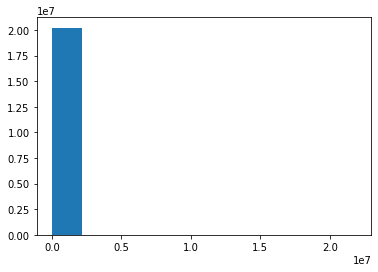

In [10]:
plt.hist(train['meter_reading'])

Nous constatons qu'il y a plein de zéros pour cette variable. Toute fois, l'histogramme ne nous permet pas de bien voir la distribution de cette variable pour les valeurs différentes de zéro. Nous allons étudier les données pour des meter reading égale à zéro séparément des autres dans un premier temps.

In [11]:
train['meter_reading'].describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

En regardant la descrirption de cette variable, la moyenne est loin de zéro. On s'intéresse donc maintenant au pourcentage de valeurs qui sont égales à zéro.

In [12]:
train[train['meter_reading']==0].shape[0] / train.shape[0]

0.09269720668180312

Environ 9.3% des valeurs des compteurs sont égales à zéro. Nous ne pouvons pas dire exactement à quoi attribuer ce phénomène. Il se pourrait que certains de ces valeurs sont égaleas à zéro parcequ'il n'y avait pas de consommation d'énergie, ou par exemple pour le dû au fait qu'en hiver on n'a pas besoin d'eau glacée.

In [13]:
len(train['meter'])

20216100

In [14]:
train['meter'].replace({0:"electricity",1:"chilledwater",2:"steam",3:"hotwater"},inplace=True)

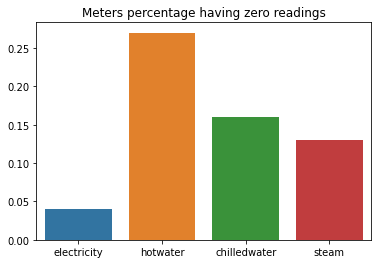

In [15]:
meter_dict = {}
for i in train['meter'].unique():
    percent = round(train[train['meter_reading']== 0]['meter'].value_counts()[i] / train['meter'].value_counts()[i],2)
    meter_dict[i] = percent
zero_meter = pd.Series(meter_dict)
sns.barplot(x=zero_meter.index, y= zero_meter)
plt.title("Meters percentage having zero readings")
plt.show()

D'après le graphique ci-dessus, on constate que le compteur d'eau chaude a plus de zéros que les autres compteurs. Mais nous avons à faire au données temporelles, et donc ce n'est peut être pas la meilleur façon de regarder cette variable. Dans ce qui suit, nous allons faire des études plus détaillées.

Nous convertissons tout d'abord la variable timestamp en objet de date et temps, et ensuite attribuons le mois correspondant à chaque date pour pouvoir étudier les tendences mensuelles de meter_reading.

In [16]:
train['meter'].unique()

train['timestamp2'] = pd.to_datetime(train["timestamp"])
train['month'] = train.timestamp2.dt.month

On représente ensuite séparément pour chaque compteur les valeurs de meter_reading par mois pour voir à quel moment on a ces valeurs sur l'année.

Text(0.5, 1.0, 'For hot water')

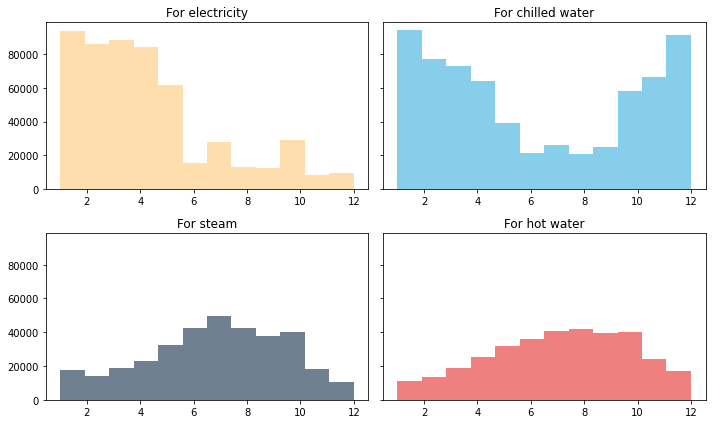

In [17]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True,figsize=(10,6))

axs[0][0].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="electricity")],bins =12,color = "navajowhite")
axs[0][0].set_title("For electricity")

axs[0][1].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="chilledwater")],bins =12,color = "skyblue")
axs[0][1].set_title("For chilled water")

axs[1][0].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="steam")],bins =12,color = "slategrey")
axs[1][0].set_title("For steam")

axs[1][1].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="hotwater")],bins =12,color = "lightcoral")
axs[1][1].set_title("For hot water")

Comme on peut le voir sur les graphes, et comme attendu, les consommation de 0 change d'un mois à l'autre sur l'année en fonction du type de compteur aussi. Pour le compteur d'électricité, on a des consommation de 0 plutôt au début de l'année jusqu'en mai environ. A partir de juin les consommation de 0 baisse. Les consommations à 0 de "steam" et d'eau chaude ont à peu près la même tendance sur l'année. Les consommations à 0 d'eau glacée sont saisonnières aussi.

En ne séparant pas les consommations à 0 du reste des consommations comme dans les graphiques ci-dessous, on n'arrive pas à voir l'effet des consommations à 0.

Text(0.5, 1.0, 'For hot water')

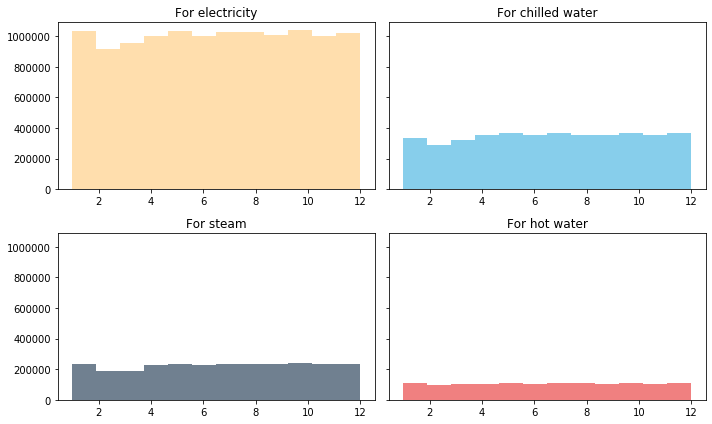

In [ ]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True,figsize=(10,6))

axs[0][0].hist(x ="month",data =train[(train.meter=="electricity")],bins =12,color = "navajowhite")
axs[0][0].set_title("For electricity")

axs[0][1].hist(x ="month",data =train[(train.meter=="chilledwater")],bins =12,color = "skyblue")
axs[0][1].set_title("For chilled water")

axs[1][0].hist(x ="month",data =train[(train.meter=="steam")],bins =12,color = "slategrey")
axs[1][0].set_title("For steam")

axs[1][1].hist(x ="month",data =train[(train.meter=="hotwater")],bins =12,color = "lightcoral")
axs[1][1].set_title("For hot water")

Les consommations différentes de 0 ont une tendance plutôt uniforme, comme ci-dessous.

Text(0.5, 1.0, 'For hot water')

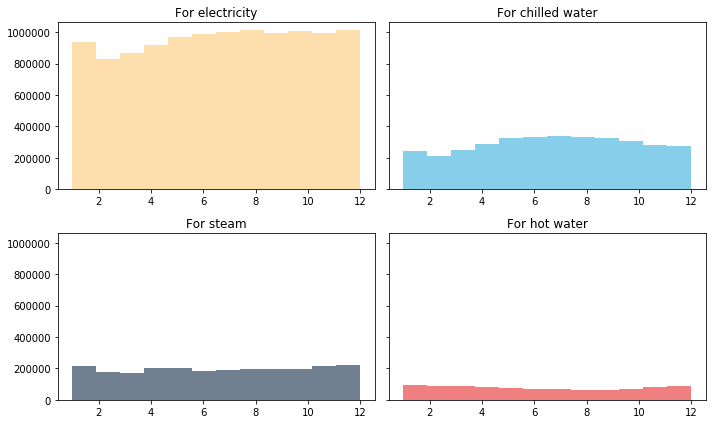

In [ ]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True,figsize=(10,6))

axs[0][0].hist(x ="month",data =train[(train.meter_reading != 0) & (train.meter=="electricity")],bins =12,color = "navajowhite")
axs[0][0].set_title("For electricity")

axs[0][1].hist(x ="month",data =train[(train.meter_reading != 0) & (train.meter=="chilledwater")],bins =12,color = "skyblue")
axs[0][1].set_title("For chilled water")

axs[1][0].hist(x ="month",data =train[(train.meter_reading != 0) & (train.meter=="steam")],bins =12,color = "slategrey")
axs[1][0].set_title("For steam")

axs[1][1].hist(x ="month",data =train[(train.meter_reading != 0) & (train.meter=="hotwater")],bins =12,color = "lightcoral")
axs[1][1].set_title("For hot water")

Text(0, 0.5, 'Probability Density')

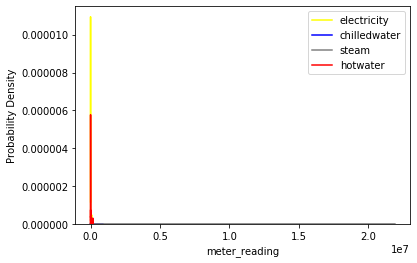

In [ ]:
sns.kdeplot(train.loc[(train['meter']=='electricity'), 
            'meter_reading'], color='yellow', shade=False, Label='electricity')

sns.kdeplot(train.loc[(train['meter']=='chilledwater'), 
            'meter_reading'], color='b', shade=False, Label='chilledwater')

sns.kdeplot(train.loc[(train['meter']=='steam'), 
            'meter_reading'], color='gray', shade=False, Label='steam')

sns.kdeplot(train.loc[(train['meter']=='hotwater'), 
            'meter_reading'], color='r', shade=False, Label='hotwater')

plt.xlabel('meter_reading') 
plt.ylabel('Probability Density') 

Nous faisons une log transformation sur la variable meter_reading pour avoir des données plus normalisées et une bonne représentation de la densité.

In [18]:
train['meter_reading_log'] = np.log1p(train['meter_reading'])

In [ ]:
sns.kdeplot(train.loc[(train['meter']=='electricity'), 
            "meter_reading_log"], color='yellow', shade=False, Label='electricity')

sns.kdeplot(train.loc[(train['meter']=='chilledwater'), 
            "meter_reading_log"], color='b', shade=False, Label='chilledwater')

sns.kdeplot(train.loc[(train['meter']=='steam'), 
            "meter_reading_log"], color='gray', shade=False, Label='steam')

sns.kdeplot(train.loc[(train['meter']=='hotwater'), 
            "meter_reading_log"], color='r', shade=False, Label='hotwater')

plt.xlabel('meter_reading_log') 
plt.ylabel('Probability Density') 

In [ ]:
len(set(train['building_id']))

1449

### Analyse des données building

Les données building_meta.csv sont composé de 6 variables définies par :

- site_id : Clé étrangère pour les fichiers météo.
- building_id : Clé étrangère pour train.csv
- primary_use : Indicateur de la catégorie principale d'activités pour le bâtiment basé sur les définitions de type de propriété EnergyStar
- square_feet : Surface de plancher brute du bâtiment
- year_built : Année d'ouverture du bâtiment
- floor_count : Nombre d'étages du bâtiment

In [ ]:
building_metadata.shape

(1449, 6)

In [ ]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
building_metadata.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [ ]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


les variables years_built et floor_count ont beaucoup de valeurs manquantes ( 774 pour years_built  et 1094 pour floor_count)

#### Variable primary_use

In [ ]:
building_metadata.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

16 types de catégorie principale d'activités pour le bâtiment, la variable primary_use peut être pris comme une varibles catégorielle.


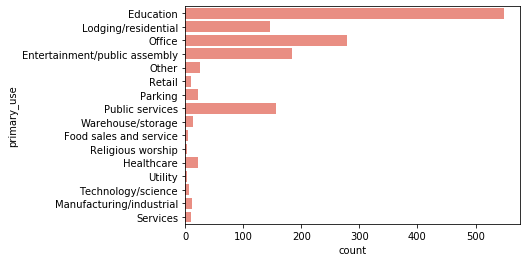

In [ ]:
sns.countplot(y="primary_use",data=building_metadata ,color="salmon")

On remarque que la majorité des acitivités des bâtiments est lié à l'éducation, et la minorité est lié a des lieux de culte religieux.  

#### Variable site_id

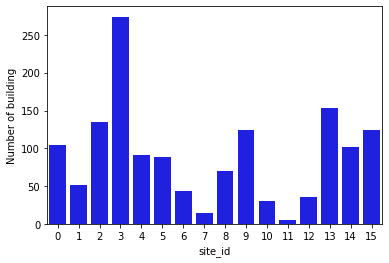

In [ ]:
site_build = building_metadata.groupby('site_id').building_id.size()
sns.barplot(x=site_build.index , y= site_build,color="blue")
plt.ylabel("Number of building")
del site_build

On remarque le site 3 a le plus grand nombre de batiments, et le site 11 en a le moins.

#### Variable square_feet, years_built et floor_count

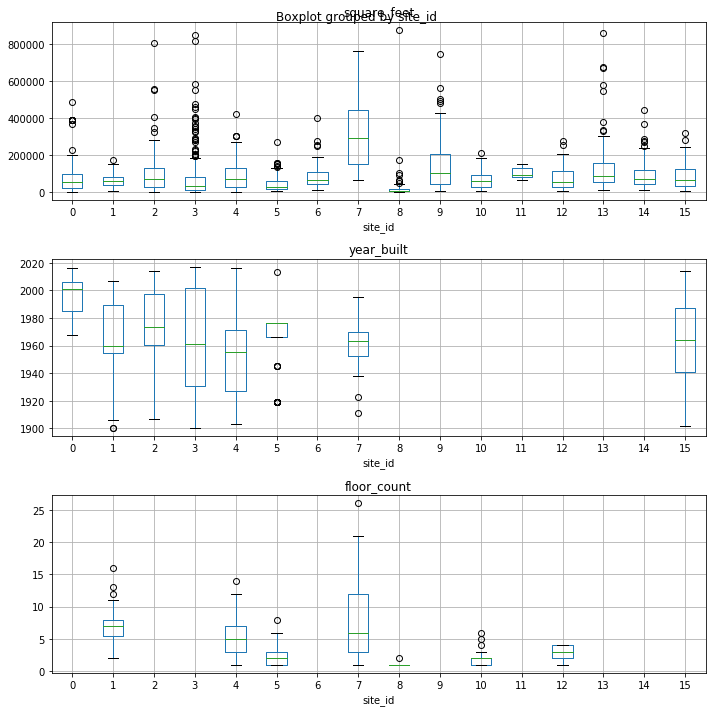

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(10,10)) 
columns = building_metadata.drop(["primary_use","site_id","building_id"],axis=1).columns
for i,col in enumerate(list(columns)):
    plot = building_metadata.boxplot(col, by="site_id", ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

On remarque que le site 0 est un site avec des bâtiments récents, et le site 4 qu'en a lui a des baitments assez anciens. Par rapport au nombres d'étages, le site 8 ne possède pas beaucoup d'étages contrairement au site 7 qui a des bâtiments avec plus d'étages.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa95b0a5ed0>]],
      dtype=object)

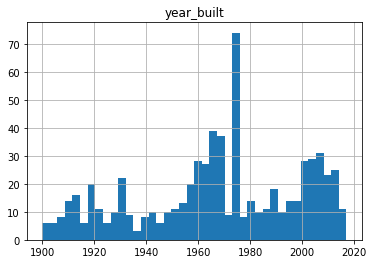

In [ ]:
building_metadata.hist(column ="year_built",bins=40)

Beaucoup de batiments datent des années 1975.

In [ ]:
building_metadata['year_built'].describe()

count     675.000000
mean     1967.957037
std        31.054030
min      1900.000000
25%      1949.000000
50%      1970.000000
75%      1995.000000
max      2017.000000
Name: year_built, dtype: float64

## Fusion base de données 

In [ ]:
x = alltrain.drop(["square_feet","year_built","meter_reading",'precip_depth_1_hr',
'sea_level_pressure', 'wind_direction','wind_speed'],axis =1)
y = alltrain["meter_reading"]

### Analyse des données méteorologiques (weather_data)

In [ ]:
weather_train.shape

(139773, 9)

La base d'apprentissage des données météorologiques comportent au total 139773 observations évaluées sur 8 variables que sont: la température de l'air, la couverture en nuage, la température de la rosée, le niveau des pluies, la pression du niveau de mer, la direction et la vitesse du vent. Chaque observation (ligne) corresponds au relevé météorologique par heure de chaque site. Ainsi, chaque site a 24 lignes pour les 8 données méteo recueillies.

In [ ]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


Toutes les données de cette base n'ont pas pu être recueillies. Il y a des valeurs manquantes pour toutes les variables mesurées sauf évidemment les heures de recueil. Les heures de recueil **timestamp** seront transformées en format date.

In [ ]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


En analysant les statistiques descriptives des variables de la table weather on peut soupçonner la présence de variables abérrantes. En effet, lorsque nous prenons les valeurs de températures, nous avons des valeurs extrêmes (min et max) très éloignées avec de fortes dispersions (std=10,62 et 9,79).
La variable precip_depth_1_hr contient à priori des variables abbérantes car la valeur minimum est de -1 alors que la valeur maximale est de 343 avec une valeur moyenne de 0.98 et des quartiles nulles.
De même, les variables de mesure du vent (wind_direction et wind_speed) présentent des caractéristiques similaires aux précédentes.
Nous pouvons vérifier la présence de valeurs abbérantes grâce au box-plot ci-dessous.

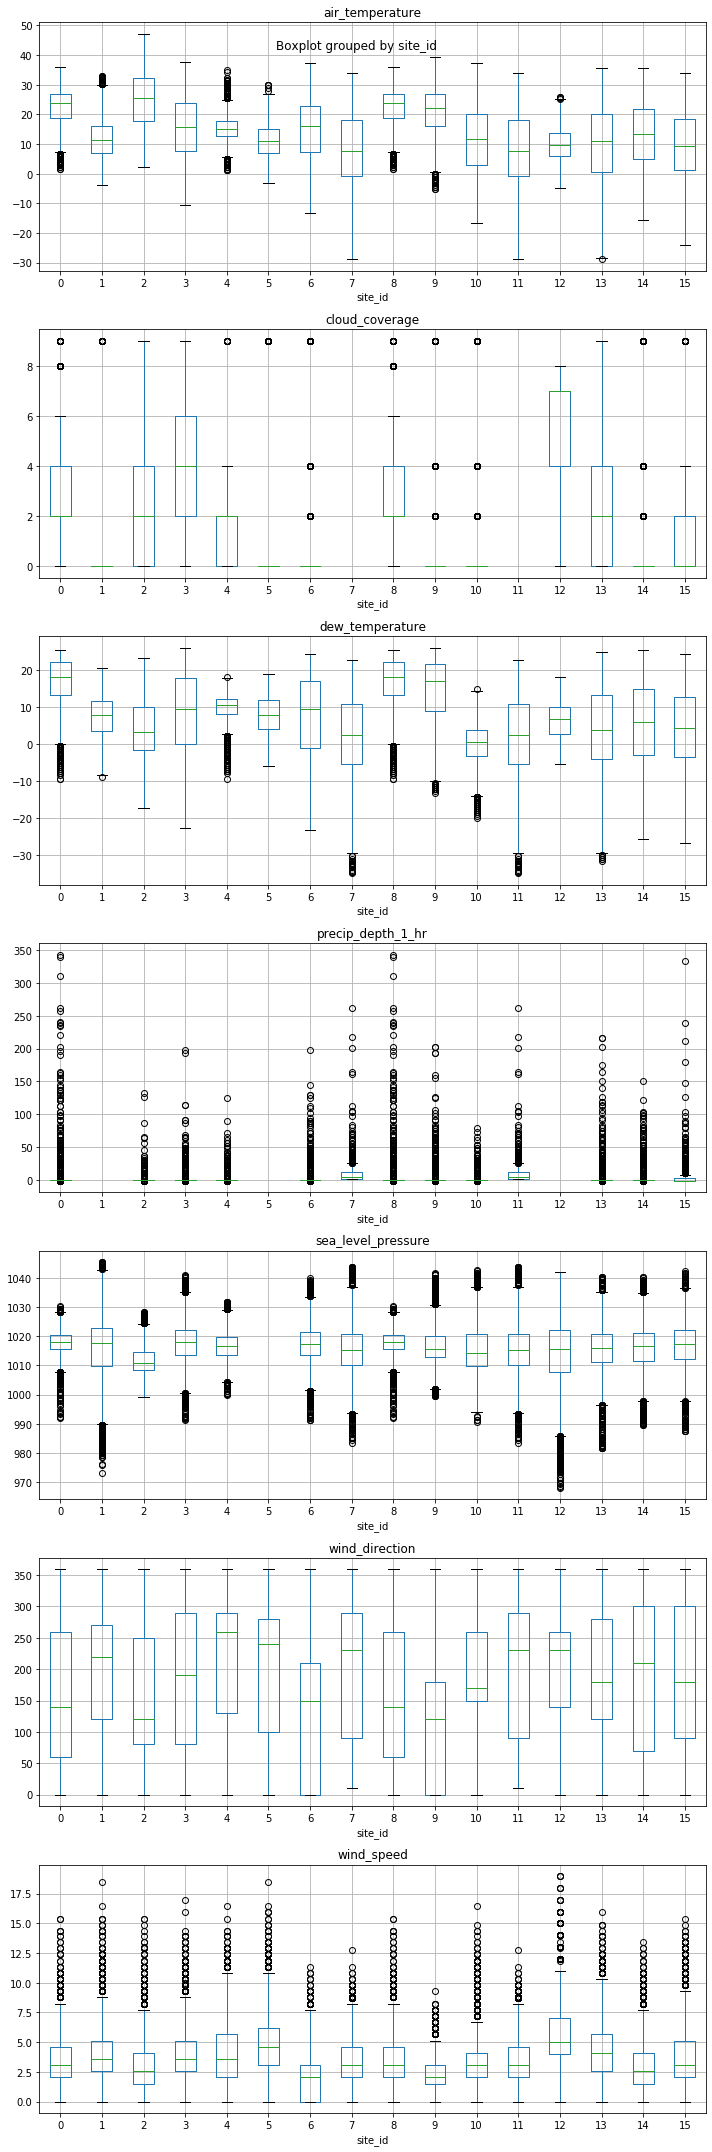

In [ ]:
fig, axes = plt.subplots(7,1,figsize=(10,30)) 
columns = weather_train.drop(["site_id","timestamp"],axis=1).columns
for i,col in enumerate(list(columns)):

    plot = weather_train.boxplot(col, by="site_id", ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

La représentation des box-plot confirme bien la présence de valeurs abbérantes pour toutes les variables d'étude de la table sauf la variable wind_direction.
Aussi, en général les données météorologiques varient en fonction des sites étudiés.
Par exemple, les sites 0, 8 et 9 ont en moyenne des températures (ambiante et de la rosée) élevées contrairement aux sites 7 et 11 avec des températures (ambiante et de la rosée) basses.
Par ailleurs, on peut également noter que nous avons très peu de données pour les variables precip_depth_1_hr et cloud_coverage. Sur le site 11, nous n'avons pas de données pour la variable cloud_coverage et sur les sites 1, 5 et 12 nous n'avons pas de données pour la variable precip_depth_1_hr.

Etudions la corrélation entre les différentes variables de la base weather_train

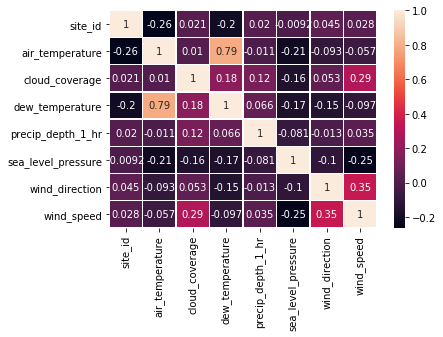

In [ ]:
sns.heatmap(weather_train.corr(),linewidths=.5,annot=True)

On obtient ci-dessus une matrice des valeurs de corrélation représentée par des couleurs. On remarque essentiellement qu'il y a une forte corrélation entre les variables **dew_temperature** et **air_température**

# Fusion des différentes tables de données

Nous avons à cette étape fusinner toutes les tables afin d'avoir une grande base de données contenant toutes les informations. Chaque table contient une clé qui permets de les référencer et donc de les fusionner entre elles.

In [6]:
train = train.merge(building_metadata, on='building_id', how='left')
alltrain = train.merge(weather_train, on=['site_id','timestamp'], how='left')
del building_metadata,weather_train,train
gc.collect()

0

In [7]:
compression_opts=dict(method='zip',archive_name='out.csv')
alltrain.to_csv('out.zip', index=False, compression=compression_opts)


In [9]:
! unzip '/content/out.zip' -d alltrain

Archive:  /content/out.zip
  inflating: alltrain/out.csv        


In [8]:
alltrain.shape

(20216100, 16)

La base de données complète contient au total 20216100 individus et 16 variables.

In [10]:
alltrain["timestamp"] = pd.to_datetime(alltrain["timestamp"])

In [11]:
numeric_col = alltrain.select_dtypes(np.number).columns.tolist()
categoric_col =alltrain.select_dtypes("object").columns.tolist()
date =alltrain.select_dtypes("datetime").columns.tolist()
print("numeric columns : {} ".format(numeric_col))
print("categorical columns : {} ".format(categoric_col))
print("datetime columns : {} ".format(date))

numeric columns : ['building_id', 'meter', 'meter_reading', 'site_id', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'] 
categorical columns : ['primary_use'] 
datetime columns : ['timestamp'] 


In [12]:
alltrain.drop(['building_id','site_id'],axis =1).describe() 

,meter,meter_reading,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,6.624412e-01,2.117121e+03,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00
std,9.309921e-01,1.532356e+05,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00
min,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.830000e+01,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,0.000000e+00,7.877500e+01,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.000000e+00,2.679840e+02,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,3.000000e+00,2.190470e+07,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


## Analyse de la table alltrain

In [ ]:
alltrain.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [ ]:
alltrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   timestamp           object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(10), int64(4), object(2)
memory usage: 2.6+ GB


**mauvaise compréhension des variables: building_id, timestamp, site_id et meter**  
## Changement des types de variables

In [ ]:
alltrain.timestamp=pd.to_datetime(alltrain['timestamp'])

In [ ]:
varia=['building_id','site_id', 'meter']

for col in varia:
    
    alltrain[col]=alltrain[col].astype('object')
    

In [ ]:
alltrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         object        
 1   meter               object        
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             object        
 5   primary_use         object        
 6   square_feet         int64         
 7   year_built          float64       
 8   floor_count         float64       
 9   air_temperature     float64       
 10  cloud_coverage      float64       
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      float64       
 15  wind_speed          float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(4)
memory usage: 2.6+ GB


In [ ]:
alltrain['meter'] = pd.Categorical(alltrain['meter']).rename_categories({0: 'electricity', 
                                                                   1: 'chilledwater',
                                                                   2: 'steam', 
                                                                   3: 'hotwater'})

## Occurence des modalités de chaque variable quali

In [ ]:
 for col in alltrain.select_dtypes(object).columns:
    print (f'{col :-<30} {len(alltrain[col].value_counts())}')

building_id------------------- 1449
site_id----------------------- 16
primary_use------------------- 16


## Analyse des valeurs manquantes

In [ ]:
(alltrain.isna().sum()/alltrain.shape[0]).sort_values(ascending=False)

floor_count           0.826528
year_built            0.599900
cloud_coverage        0.436551
precip_depth_1_hr     0.185447
wind_direction        0.071678
sea_level_pressure    0.060925
wind_speed            0.007107
dew_temperature       0.004953
air_temperature       0.004781
square_feet           0.000000
primary_use           0.000000
site_id               0.000000
meter_reading         0.000000
timestamp             0.000000
meter                 0.000000
building_id           0.000000
dtype: float64

## Encodage de la variable primary_use

In [ ]:
alltrain.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [ ]:
alltrainEncod=pd.concat([alltrain, pd.get_dummies(alltrain["primary_use"], 
                                            dtype=int) ], axis=1)

In [ ]:
alltrainEncod

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,0,electricity,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,NaN,25.0,...,0,0,0,0,0,0,0,0,0,0
1,1,electricity,2016-01-01 00:00:00,0.000,0,Education,2720,2004.0,NaN,25.0,...,0,0,0,0,0,0,0,0,0,0
2,2,electricity,2016-01-01 00:00:00,0.000,0,Education,5376,1991.0,NaN,25.0,...,0,0,0,0,0,0,0,0,0,0
3,3,electricity,2016-01-01 00:00:00,0.000,0,Education,23685,2002.0,NaN,25.0,...,0,0,0,0,0,0,0,0,0,0
4,4,electricity,2016-01-01 00:00:00,0.000,0,Education,116607,1975.0,NaN,25.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,electricity,2016-12-31 23:00:00,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,...,0,0,0,0,0,0,0,0,0,0
20216096,1445,electricity,2016-12-31 23:00:00,4.825,15,Education,4298,NaN,NaN,1.7,...,0,0,0,0,0,0,0,0,0,0
20216097,1446,electricity,2016-12-31 23:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,...,0,0,0,0,0,0,0,0,0,0
20216098,1447,electricity,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,...,0,0,0,0,0,0,0,0,0,0
